# Damped 1-DOF System Response**

This problem involves calculating the response of a damped single-degree-of-freedom (1-DOF) system subjected to harmonic excitation.
The system parameters and initial conditions are as follows:

## System Parameters:
- Mass \( m = 2 \)
- Damping Coefficient \( c = 10 \)
- Stiffness \( k = 1000 \)

## Harmonic Excitation:
- Force Amplitude \( F_0 = 3 \)
- Excitation Frequency \( ω \) is randomly defined between 0 and 10π\.
- Phase Angle \( ϕ = $\frac{\pi}{3}$ \)

## Initial Conditions:
- Initial Displacement \( u(0) = 0.5 \)
- Initial Velocity \( $\dot{u}(0)$ = 0 \)

## Governing Equation:
The equation of motion for the system is:
$[
    m \ddot{u}(t) + c \dot{u}(t) + k u(t) = F_0 \cos(\omega t + \phi)
$\]

The solution involves solving this second-order differential equation numerically to obtain the displacement response $ u(t) $\.

The implementation uses PyTorch for numerical simulation.



# DeepONet Application:
In addition, DeepONet is utilized to predict the system's response under varying excitation frequencies. This approach enables efficient learning and prediction of the system's dynamic behavior, bypassing the need for solving the differential equation repeatedly for different excitation inputs.


In [82]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange

# Generate Dataset

In [149]:
def exact_solution(f, t):
    """
    Compute the exact solution for the response of a damped harmonic oscillator under forced excitation.

    Parameters:
    f: Forcing frequency (scalar)
    t: Time or independent variable (torch tensor)
    """
    # Define system parameters
    m = 2  # Mass of the system
    c = 10  # Damping coefficient
    k = 1000  # Stiffness of the spring

    wn = np.sqrt(k / m)  # Natural (undamped) angular frequency
    zeta = c / (2 * np.sqrt(m * k))  # Damping ratio (dimensionless)
    wd = wn * np.sqrt(1 - zeta**2)  # Damped natural angular frequency

    A = 3  # Amplitude of the external forcing function
    f_phase = np.pi / 3  # Phase of the forcing function (not directly used in this calculation)

    x0 = 0.5  # Initial displacement
    v0 = 0  # Initial velocity

    # Compute the steady-state response due to the external forcing
    H = A / (m * np.sqrt((wn**2 - f**2)**2 + (2 * zeta * wn * f)**2))  # Magnitude of the transfer function
    phi = np.arctan((2 * zeta * wn * f) / (wn**2 - f**2))  # Phase angle of the steady-state response
    steady_state_response = H * np.cos(f * t - phi)  # Steady-state displacement as a function of time

    # Compute the transient response due to initial conditions
    a = x0 - steady_state_response[0]  # Initial displacement offset from steady-state response
    b = (v0 + zeta * wn * a) / wd  # Initial velocity contribution to the transient response

    # Transient response: decaying oscillatory motion due to initial conditions
    transient_response = (
        np.exp(-zeta * wn * t) * (a * np.cos(wd * t) + b * np.sin(wd * t))
    )
    # Total response
    return steady_state_response + transient_response

In [150]:
t = torch.linspace(0, 1, 50)  # Time vector ranging from 0 to 1 with 50 evenly spaced points

f = torch.linspace(0, 10 * np.pi, 100)  # Forcing frequency range from 0 to 10π with 100 points

responses1 = []  # To store exact solutions for the forced response
responses2 = []  # To store purely sinusoidal forcing functions for comparison

# Compute the system response for each forcing frequency
for i in f:
    # Append the exact solution (response of the system) for each forcing frequency
    responses1.append(exact_solution(i, t))
    # Append the sinusoidal forcing function for comparison
    responses2.append(3 * torch.cos(i * t + torch.pi / 3))

# Flatten the exact solutions into a single array for easier handling
exact_sol = np.array(responses1).flatten()

# Convert the sinusoidal forcing functions into a numpy array
u = np.array(responses2)  # Create a 2D array where rows represent different frequencies
u_total = np.repeat(u, repeats=50, axis=0)  # Repeat each frequency's response to match time steps

# Create a tiled time array for input pairing
y_total = np.tile(t, (1, 100)).T  # Repeat the time array for each frequency (shape adjusted to match `u_total`)

# Split data into training and testing datasets
u_train = torch.tensor(u_total[:4000])
y_train = torch.tensor(y_total[:4000])
u_test = torch.tensor(u_total[4000:])
y_test = torch.tensor(y_total[4000:])

# Split the exact solutions into training and testing datasets
train_sol = torch.tensor(exact_sol[:4000])
test_sol = torch.tensor(exact_sol[4000:])

#Define DeepONet Model

In [151]:
class DeepONet(nn.Module):
    def __init__(self):
        super(DeepONet, self).__init__()
        # Define the branch network layers
        # The branch network processes input 'u' and extracts relevant features
        self.branch_layer1 = nn.Linear(50, 100)  # 1st layer: input size 50, output size 100
        self.branch_layer2 = nn.Linear(100, 100)  # 2nd layer
        self.branch_layer3 = nn.Linear(100, 100)  # 3rd layer
        self.branch_layer4 = nn.Linear(100, 100)  # 4th layer
        self.branch_layer5 = nn.Linear(100, 100)  # 5th layer
        self.branch_layer6 = nn.Linear(100, 100)  # 6th and final layer
        # Define the trunk network layers
        # The trunk network processes input 'y' and extracts relevant features
        self.trunk_layer1 = nn.Linear(1, 100)  # 1st layer: input size 1 (scalar input), output size 100
        self.trunk_layer2 = nn.Linear(100, 100)  # 2nd layer
        self.trunk_layer3 = nn.Linear(100, 100)  # 3rd layer
        self.trunk_layer4 = nn.Linear(100, 100)  # 4th layer
        self.trunk_layer5 = nn.Linear(100, 100)  # 5th layer
        self.trunk_layer6 = nn.Linear(100, 100)  # 6th and final layer
        # Define the activation function
        self.activation = nn.Tanh()  # Use the Tanh activation function for non-linearity

    def forward(self, u, y):
        B = self.Branch_net(u)  # Process input 'u' through the branch network
        T = self.Trunk_net(y)  # Process input 'y' through the trunk network
        output = torch.sum(B * T, dim=-1)  # Perform the dot product of branch and trunk outputs
        return output  # Return the final output

    # Define the branch network's processing
    def Branch_net(self, u):
        u = self.activation(self.branch_layer1(u))  # Pass through the 1st layer and apply activation
        u = self.activation(self.branch_layer2(u))  # 2nd layer with activation
        u = self.activation(self.branch_layer3(u))  # 3rd layer with activation
        u = self.activation(self.branch_layer4(u))  # 4th layer with activation
        u = self.activation(self.branch_layer5(u))  # 5th layer with activation
        return self.branch_layer6(u)  # Final layer without activation

    # Define the trunk network's processing
    def Trunk_net(self, y):
        y = self.activation(self.trunk_layer1(y))  # Pass through the first layer and apply activation
        y = self.activation(self.trunk_layer2(y))  # Second layer with activation
        y = self.activation(self.trunk_layer3(y))  # Third layer with activation
        y = self.activation(self.trunk_layer4(y))  # Fourth layer with activation
        y = self.activation(self.trunk_layer5(y))  # Fifth layer with activation
        return self.trunk_layer6(y)  # Final layer without activation


# Train DeepONet

In [152]:
model = DeepONet() # Initialize the DeepONet model
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # Use the Adam optimizer with a learning rate of 0.001

Iteration = 4000  # Total number of training iterations
pbar = trange(Iteration)  # Display a progress bar to monitor the training process
loss_log = []

# Training loop
for i in pbar:
    pred = model(u_train, y_train) # Forward pass: predict outputs for training inputs using the model

    loss = torch.mean((pred - train_sol) ** 2)  # Mean Squared Error (MSE) between predictions and ground truth

    optimizer.zero_grad()  # Clear any gradients accumulated in the previous step
    loss.backward()  # Perform backpropagation to calculate gradients
    optimizer.step()  # Apply the gradient updates to the model parameters

    pbar.set_postfix(loss=loss.item())  # Display the current loss in the progress bar
    loss_log.append(loss.item())  # Store the loss value for later analysis

100%|██████████| 4000/4000 [06:07<00:00, 10.87it/s, loss=4.68e-5]


## Visualize train

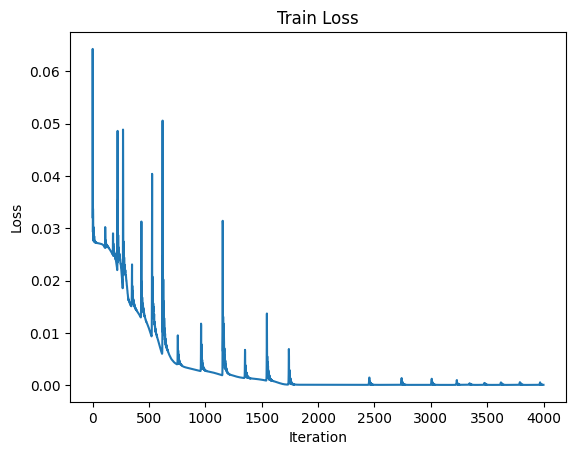

In [153]:
x = np.arange(len(loss_log))  # Generate a range of integers from 0 to the length of loss_log
plt.plot(x, loss_log)  # Plot the loss values (y-axis) against the iterations (x-axis)
plt.title('Train Loss')  # Title to describe the plot
plt.xlabel('Iteration')  # The x-axis represents the training iterations
plt.ylabel('Loss')  # The y-axis represents the loss values
plt.show()  # Display the plot

# Evaluate Test data

In [154]:
# Use the trained model to predict test outputs.
test_pred = model(u_test, y_test).detach().numpy()

# Calculate the Root Mean Squared Error (RMSE)
RMSE = np.sqrt(np.mean((test_pred - test_sol.numpy())**2))  # Apply the square root to calculate the RMSE.

# Output the RMSE value to evaluate the model's prediction accuracy.
print(f'RMSE is {RMSE}')

RMSE is 0.007454968523234129


## Visualize predict

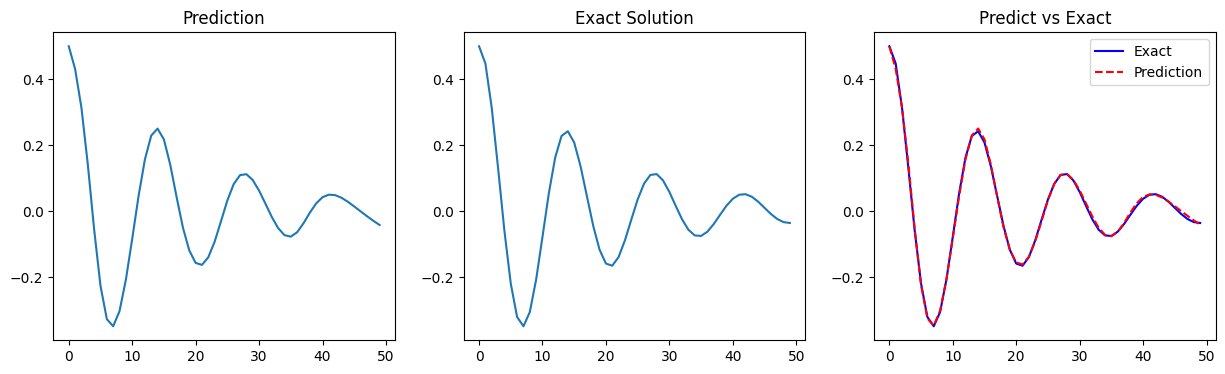

In [155]:
# Create an x-axis array for the first 50 points
x = np.arange(50)  # Generate integers from 0 to 49 for plotting the first 50 samples
# Set up the figure size for the plots
plt.figure(figsize=(15, 4))  # Create a figure with dimensions 15x4
# Plot the predictions in the first subplot
plt.subplot(1, 3, 1)
plt.plot(x, test_pred[:50])  # Plot the first 50 prediction values
plt.title('Prediction')
# Plot the exact solution in the second subplot
plt.subplot(1, 3, 2)
plt.plot(x, test_sol[:50])  # Plot the first 50 exact solution values
plt.title('Exact Solution')
# Plot both predictions and exact solutions in the third subplot
plt.subplot(1, 3, 3)
plt.plot(x, test_sol[:50], color='blue', label='Exact')  # Plot the exact solution in blue
plt.plot(x, test_pred[:50], linestyle='dashed', color='red', label='Prediction')  # Plot predictions in dashed red
plt.legend()
plt.title('Predict vs Exact')
# Display the plots
plt.show()